In [1]:
import StableDiffusion.ModelConverter
from StableDiffusion.DiffusionProcess import DiffusionProcess
device = 'cuda'
idleDevice = 'cpu'
#diffusionDict = StableDiffusion.ModelConverter.load_from_standard_weights(input_file='./models/inkpunk-diffusion-v1.ckpt',\
#                                                            device = 'cuda')
diffusionDict = StableDiffusion.ModelConverter.load_from_standard_weights(input_file='../models/sd15models/v1-5-pruned-emaonly.ckpt',\
                                                            device = 'cuda')
clipWeights=diffusionDict['clip']
diffusionWeights = diffusionDict['diffusion']
vaeEncoderWeights = diffusionDict['encoder']
vaeDecoderWeights = diffusionDict['decoder']



import torch 
import StableDiffusion.VaeEncoder 
import StableDiffusion.VaeDecoder
import StableDiffusion.ClipEncoder
import StableDiffusion.DiffusionProcess
import importlib
importlib.reload(StableDiffusion.VaeEncoder)
importlib.reload(StableDiffusion.VaeDecoder)
importlib.reload(StableDiffusion.ClipEncoder)
importlib.reload(StableDiffusion.DiffusionProcess)
from StableDiffusion.VaeDecoder import VaeDecoder
from StableDiffusion.VaeEncoder import VaeEncoder
from StableDiffusion.ClipEncoder import ClipEncoder
from StableDiffusion.DiffusionProcess import DiffusionProcess
clipEncoder = ClipEncoder().to(device)
vaeEncoder = VaeEncoder().to(device)
vaeDecoder = VaeDecoder().to(device)
diffusionProcess = DiffusionProcess().to(device)
clipEncoder.load_state_dict(clipWeights,strict=True)
vaeEncoder.load_state_dict(vaeEncoderWeights ,strict=True)
vaeDecoder.load_state_dict(vaeDecoderWeights,strict=True)
diffusionProcess.load_state_dict(diffusionWeights,strict=True)
clipName = clipEncoder.__class__.__name__
print(clipName)


/home/aistudio/external-libraries/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ClipEncoder


torch.Size([1, 3, 512, 512])


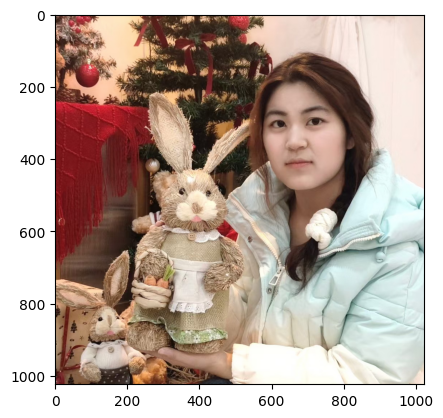

token embedding shape torch.Size([1, 77, 768])
token embedding shape torch.Size([1, 77, 768])
input image is none,use random noise instead
timesteps typetorch.int64


  2%|▏         | 1/50 [00:00<00:06,  7.60it/s]

timesteps  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:08<00:00,  6.20it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5435903..1.3711679].


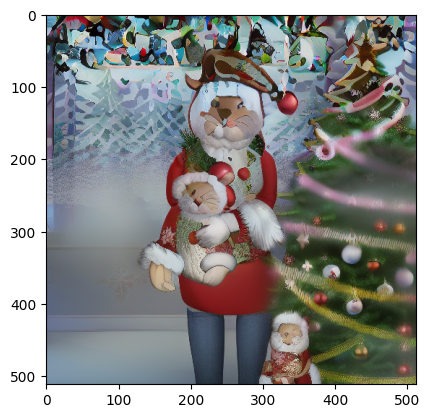

In [13]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
import torch
from transformers import CLIPTokenizer
import numpy as np
from StableDiffusion.Utils import Utils
import matplotlib.pyplot as plt
import StableDiffusion.DdpmSamplerTorch
import StableDiffusion.TimeEmbedding
import StableDiffusion.Utils
import StableDiffusion.UnetGlobalCrossAttentionBlock
import StableDiffusion.UnetDenoise
import importlib
importlib.reload(StableDiffusion.DdpmSamplerTorch)
importlib.reload(StableDiffusion.TimeEmbedding)
importlib.reload(StableDiffusion.Utils)
importlib.reload(StableDiffusion.UnetGlobalCrossAttentionBlock)
importlib.reload(StableDiffusion.UnetDenoise)
from StableDiffusion.DdpmSamplerTorch import DdpmSamplerTorch
from StableDiffusion.TimeEmbedding import TimeEmbedding
from StableDiffusion.Utils import Utils
from StableDiffusion.UnetGlobalCrossAttentionBlock import UnetGlobalCrossAttentionBlock
from StableDiffusion.UnetDenoise import UnetDenoise
#img1 = cv2.imread('./images/pusiyue_front_1024_1024.jpg')
#img1 = cv2.imread('./images/apple.jpg')
filePath = './images/apple.jpg'
filePath ='./images/pusiyue_front_1024_1024.jpg'
imgBatch = Utils.loadImageBatch(filePath)
Width = 512
Height = 512
LatentWidth = Width//8
LatentHeight = Height//8
LatentShape = (1,4,LatentHeight,LatentWidth)
#LatentShape = (4,4,LatentHeight,LatentWidth)
imgBatch = imgBatch.to(device)
inputImage = imgBatch
inputImage = None
isDoingCfg = True
#isDoingCfg = False
numInferenceSteps = 50
#cfgScale = 7.5
cfgScale = 15
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# This forces the GPU to use slower, deterministic algorithms
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

randomGenerator = torch.Generator(device=device)
randomGenerator.manual_seed(seed)
sampler = DdpmSamplerTorch(randomGenerator=randomGenerator,
                           numTrainingSteps=1000,
                           numInferenceSteps=numInferenceSteps)
promptPositive = [#'a girl walking on a Chrismas street in a snowing day', \
           'a woman holding two stuffed rabbits in front of a christmas tree',      
        #'a cat sitting by window while snow falls from the sky',
        #'10 cat'
        #'1boy'
        #'a girl playing with a cat in a snowing day'
        #'a cat sitting by window while snow falls from the sky'
        #'a girl holding a bundle of flowers in a vase,highresolutin,masterpiece,best quality,8k'
        ]
#promptNegative = ['blur, ugly, bad, poor']    
promptNegative =['lowres, {bad}, error, fewer, extra,\
                 missing, worst quality, jpeg artifacts, \
                 bad quality, watermark, unfinished, \
                displeasing, chromatic aberration, signature, \
                    extra digits, artistic error, username, \
                        scan, [abstract]']
promptPositiveTokens = Utils.getPromptTokens(promptPositive,device=device)
promptNegativeTokens = Utils.getPromptTokens(promptNegative,device=device)
clipInputsPositive =promptPositiveTokens
clipInputsNegative = promptNegativeTokens
vaeEncoder.eval()
vaeDecoder.eval()
diffusionProcess.eval()
clipEncoder.eval()
imgStepList = []
with torch.no_grad():
    clipOutputsPositive = clipEncoder(clipInputsPositive)
    clipOutputsNegative = clipEncoder(clipInputsNegative)    
    #print(clipOutputs)
    
    if isDoingCfg == True:
        clipOutputs = torch.cat([clipOutputsPositive,clipOutputsNegative])
    else:
        clipOutputs = clipOutputsPositive
        
    
    if inputImage is not None:
        
        print(f'use input image to guide image generation')
        inputNoise =torch.randn(LatentShape,generator=randomGenerator,device=device)      
        #inputNoise = None
        latentNoised = vaeEncoder(inputImage,inputNoise)
        sampler.setAddNoiseStrength(0.8)
        time = sampler.getInferenceTimeSteps()[0].to(device)
        latentNoised = sampler.addNoise(latentNoised,time)
        imageDecodedDirect = vaeDecoder(latentNoised)       
        Utils.showBatchImage(imageDecodedDirect)
        
    else: 
        print(f'input image is none,use random noise instead')
        latentNoised = torch.randn(LatentShape,generator=randomGenerator,device=device)
    
    timesteps = sampler.getInferenceTimeSteps() 
    print(f'timesteps type{timesteps.dtype}')       
    
    timesteps = tqdm(timesteps)
    print(f'timesteps{timesteps}')
    for i,time in enumerate(timesteps):
        #print(f'i step: {i} time step: {time} {time.device}')              
        timeEmbedding320 = Utils.getTimeEmbedding(time)    
        timeEmbedding320= sampler.numpy2Tensor(timeEmbedding320,device=device)
        modelNoisedLatentInput = latentNoised
        contextInput = clipOutputs
        if isDoingCfg == True:
            #print(f'is doing cfg scale {cfgScale}')
            modelNoisedLatentInput = modelNoisedLatentInput.repeat(2,1,1,1)
            #print(f'doing cfg scale latent inputs shape  {modelNoisedLatentInput.shape}') 
        
        #print(f'latentinput device: {modelNoisedLatentInput.device}  contextinput device: {contextInput.device} timeembed device: {timeEmbedding320.device}')
        #print(f'latent input: {modelNoisedLatentInput} contextinput: {contextInput} timeinput: {timeEmbedding320}')
        #print(f'latent input: {modelNoisedLatentInput.shape} contextinput: {contextInput.shape} timeinput: {timeEmbedding320.shape}')
        modelEstimatedNoiseInLatent  = diffusionProcess(modelNoisedLatentInput,contextInput,timeEmbedding320)
        
        if isDoingCfg == True:
            #print(f'is doing cfg scale {cfgScale}')
            positiveEstimate,negativeEstimate = modelEstimatedNoiseInLatent.chunk(2,dim=0)
            #print(modelEstimatedNoiseInLatent.shape,positiveEstimate.shape,negativeEstimate.shape)
            modelEstimatedNoiseInLatent = cfgScale * positiveEstimate  + (1-cfgScale) * negativeEstimate
            #print(f'after cfg scale {positiveEstimate.shape} {negativeEstimate.shape} {modelEstimatedNoiseInLatent.shape}')
            modelNoisedLatentInput = latentNoised
            #added 20260223 to make sure the input back to batch size 1
        

        #print(f'latent  noise  time input beforme remove noise  {modelNoisedLatentInputNumpy.shape} context input {contextInputNumpy.shape} time embedding {timeEmbedding320Numpy.shape}')
        cleanerLatent = sampler.removeNoiseFromLatent(modelNoisedLatentInput,modelEstimatedNoiseInLatent,time)        
        latentNoised  = cleanerLatent
        #print(f'latent input at the end while step {i} {latentNoised.shape}')
        
        #print(f'latent noised {latentNoised.shape} {latentNoised}')
        imageDecoded = vaeDecoder(latentNoised)
        imgStepList.append(imageDecoded)
        #if i % 10 == 0:
            #imageDecoded = vaeDecoder(latentNoised)         
            #Utils.showBatchImage(imageDecoded)
        

Utils.showBatchImage(imgStepList[-1]) 
#imageDecoded = vaeDecoder(latentNoised)         
#Utils.showBatchImage(imageDecoded)    


    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62699866..1.3889787].


50
50


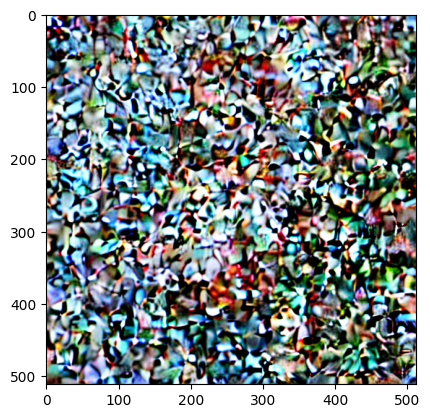

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56793904..1.3552756].


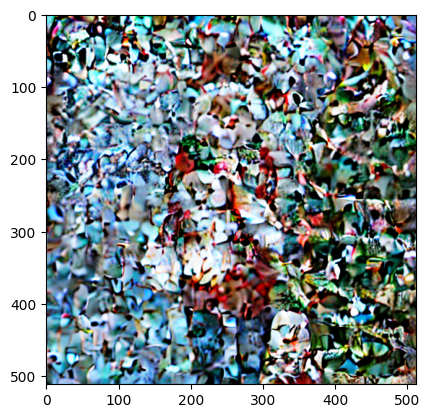

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5435903..1.3711679].


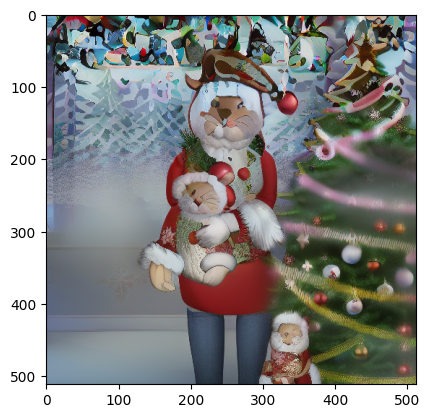

In [14]:
print(len(imgStepList))
timeSteps = sampler.getInferenceTimeSteps()
ListLength = timeSteps.shape[0]
print(ListLength)
Utils.showBatchImage(imgStepList[ListLength//3])
Utils.showBatchImage(imgStepList[ListLength//3 *2-1])
Utils.showBatchImage(imgStepList[ListLength-1])

in ddpm start step is 9
timesteps: tensor([900, 890, 880, 870, 860, 850, 840, 830, 820, 810, 800, 790, 780, 770,
        760, 750, 740, 730, 720, 710, 700, 690, 680, 670, 660, 650, 640, 630,
        620, 610, 600, 590, 580, 570, 560, 550, 540, 530, 520, 510, 500, 490,
        480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350,
        340, 330, 320, 310, 300, 290, 280, 270, 260, 250, 240, 230, 220, 210,
        200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100,  90,  80,  70,
         60,  50,  40,  30,  20,  10,   0])
noise time step start : 900
vae encoder input noise is none  use zeros


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57412386..1.3030851].


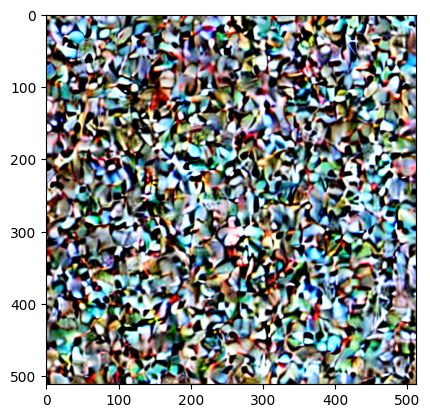

In [95]:
sampler = DdpmSamplerTorch(randomGenerator=randomGenerator,
                           numTrainingSteps=1000,
                           numInferenceSteps=numInferenceSteps)
sampler.setAddNoiseStrength(0.9)
timeSteps = sampler.getInferenceTimeSteps()
print(f'timesteps: {timeSteps}')
time = sampler.getInferenceTimeSteps()[0].to(device)
print(f'noise time step start : {time }')
latentNoised = vaeEncoder(inputImage.to(device))
latentNoised = sampler.addNoise(latentNoised,time)
imageDecodedDirect = vaeDecoder(latentNoised)       
Utils.showBatchImage(imageDecodedDirect)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74650323..2.2043948].


use input image to guide image generation
vae encoder input noise.shape torch.Size([1, 4, 64, 64])


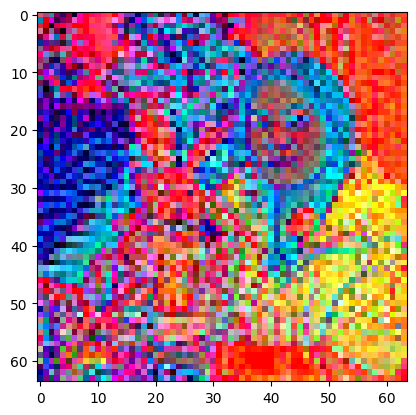

In [96]:
print(f'use input image to guide image generation')
inputNoise =torch.randn(LatentShape,generator=randomGenerator,device=device)      

latentNoised = vaeEncoder(inputImage,inputNoise)
Utils.showBatchImage(latentNoised[0:,1:,:,:])

In [26]:
print(LatentShape)

(1, 4, 64, 64)


In [25]:
print(f'sampler.alphas {sampler.alphas}')
print(f'sampler.betas {sampler.betas}')
print(f'sampler.alphasBar {sampler.alphasBar}')
print(f'sampler.betasBar {sampler.betasBar}')


sampler.alphas tensor([0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991, 0.9991,
        0.9991, 0.9991, 0.9991, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9990,
        0.9990, 0.9990, 0.9990, 0.9990, 0.9990, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989,
        0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9989, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988,
        0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9988, 0.9987, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9987,
        0.9987, 0.9987, 0.9987, 0.9987, 0.9987, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986, 0.9986,
        0.9986, 0.9986, 0

In [22]:
sampler.getInferenceTimeSteps()


tensor([990, 980, 970, 960, 950, 940, 930, 920, 910, 900, 890, 880, 870, 860,
        850, 840, 830, 820, 810, 800, 790, 780, 770, 760, 750, 740, 730, 720,
        710, 700, 690, 680, 670, 660, 650, 640, 630, 620, 610, 600, 590, 580,
        570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470, 460, 450, 440,
        430, 420, 410, 400, 390, 380, 370, 360, 350, 340, 330, 320, 310, 300,
        290, 280, 270, 260, 250, 240, 230, 220, 210, 200, 190, 180, 170, 160,
        150, 140, 130, 120, 110, 100,  90,  80,  70,  60,  50,  40,  30,  20,
         10,   0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61985385..1.3449364].


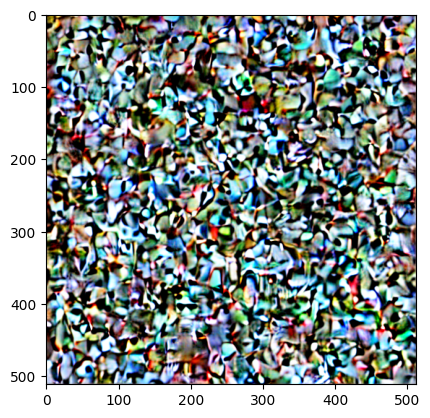

In [62]:
imageDecoded = vaeDecoder(latentNoised)         
Utils.showBatchImage(imageDecoded)   

In [8]:
timeEmbed = Utils.getTimeEmbedding(0)
print(timeEmbed)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
sampler.getVariance(940)
sampler.getVariance(10)

tensor(1.0000e-20)

In [13]:
sampler.deltaSteps
sampler.getPreviousTimeStep(960)
sampler.betas
sampler.alphasBar

tensor([0.9991, 0.9983, 0.9974, 0.9966, 0.9957, 0.9948, 0.9940, 0.9931, 0.9922,
        0.9913, 0.9904, 0.9895, 0.9886, 0.9877, 0.9868, 0.9859, 0.9850, 0.9841,
        0.9832, 0.9822, 0.9813, 0.9804, 0.9794, 0.9785, 0.9776, 0.9766, 0.9757,
        0.9747, 0.9737, 0.9728, 0.9718, 0.9708, 0.9698, 0.9689, 0.9679, 0.9669,
        0.9659, 0.9649, 0.9639, 0.9629, 0.9619, 0.9609, 0.9599, 0.9588, 0.9578,
        0.9568, 0.9557, 0.9547, 0.9537, 0.9526, 0.9516, 0.9505, 0.9495, 0.9484,
        0.9473, 0.9463, 0.9452, 0.9441, 0.9430, 0.9420, 0.9409, 0.9398, 0.9387,
        0.9376, 0.9365, 0.9354, 0.9343, 0.9332, 0.9320, 0.9309, 0.9298, 0.9287,
        0.9275, 0.9264, 0.9252, 0.9241, 0.9229, 0.9218, 0.9206, 0.9195, 0.9183,
        0.9171, 0.9160, 0.9148, 0.9136, 0.9124, 0.9112, 0.9100, 0.9089, 0.9077,
        0.9065, 0.9052, 0.9040, 0.9028, 0.9016, 0.9004, 0.8992, 0.8979, 0.8967,
        0.8955, 0.8942, 0.8930, 0.8917, 0.8905, 0.8892, 0.8880, 0.8867, 0.8854,
        0.8842, 0.8829, 0.8816, 0.8804, 

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
# Add the specific global that caused the crash
torch.serialization.add_safe_globals(["pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint"])

ckpt_path = "/home/aistudio/models/sd15models/v1-5-pruned-emaonly.ckpt"

# Updated loader with weights_only=False
pipe = StableDiffusionPipeline.from_single_file(
    ckpt_path,
    torch_dtype=torch.float32,
    use_safetensors=False,
    load_safety_checker=False,
    weights_only=False  # <--- Add this line here
)

if torch.cuda.is_available():
    pipe = pipe.to("cuda")
    pipe.enable_attention_slicing()
    print("Model moved to GPU.")
else:
    print("CUDA not available. Running on CPU (slow).")

promptPositive = "a cinematic portrait of a wizard, high fantasy, detailed oil painting"

# Recommended: Wrap in autocast for float16 performance
with torch.autocast("cuda"):
    image = pipe(
        promptPositive,
        num_inference_steps=30,
        guidance_scale=7.5
    ).images[0]

image.save("wizard.png")